In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import gmean

0.0004997501249375312


CosmoComputationError: 

Error in Class: thermodynamics_init(L:404) :error in thermodynamics_solve(ppr,pba,pth,ptw,pvecback);
=>thermodynamics_solve(L:1614) :error in generic_evolver(thermodynamics_derivs, interval_limit[index_interval], interval_limit[index_interval+1], ptw->ptdw->ptv->y, ptw->ptdw->ptv->used_in_output, ptw->ptdw->ptv->ti_size, &tpaw, ppr->tol_thermo_integration, ppr->smallest_allowed_variation, thermodynamics_timescale, ppr->thermo_integration_stepsize, mz_output, pth->tt_size, thermodynamics_sources, ((void *)0), pth->error_message);
=>evolver_ndf15(L:466) :condition (absh <= hmin) is true; Step size too small: step:1.288e-11, minimum:1.288e-11, in interval: [-8050:-4600]


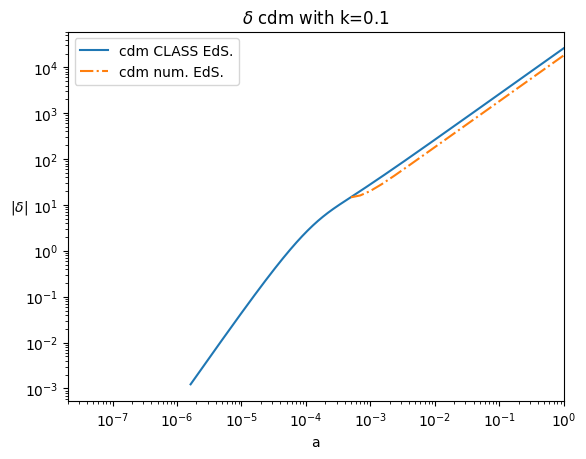

In [5]:


def f(k_ind=0):#,Omega_M=0.99):
    #Omega_M = 0.31
    Omega_M = 0.98
    Omega_b = 0.01
    Omega_lambda = 1 - Omega_b - Omega_M
    kvec = [0.1,1,10]
    #k_ind = 0
    mv_test = .1
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    plt.figure(k_ind)#np.random.randint(1,1000))
    plt.loglog(a,-cdm,label="cdm CLASS EdS.")#a,-neutrino)
    #plt.loglog(a,-neutrino)

    tau = pb["tau [Mpc]"]

    a_interp = scipy.interpolate.interp1d(tau,a)
    z = 2000
    a0 = 1/(z+1)
    #a0 = 4e-4
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    theta_interp = scipy.interpolate.interp1d(a,pb["theta_cdm"])
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)

    def cdm_func(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a) * theta ) / (a*H(a))
        return [d_delta,d_theta]
    h = 1.1
    #diff = (delta_interp(a0*h) - delta_interp(a0/h))#/(h*a0 - a0/h)
    #print(diff)
    y01 = [delta_interp(a0),5e-3]#theta_interp(a0)]
    a_span = [a0,1]
    
    
    sol = sc.solve_ivp(cdm_func, t_span = a_span, y0 = y01)
    t_sol = sol.t
    delta_sol = sol.y[0]
    plt.loglog(t_sol,-delta_sol,"-.",label="cdm num. EdS.")
    #plt.figure() 
    """def cdm_func1(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a,0.99,0.01))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a,0.99,0.01) * theta ) / (a*H(a,0.99,0.01))
        return [d_delta,d_theta]
    
    sol = sc.solve_ivp(cdm_func1, t_span = a_span, y0 = y01)
    t_sol = sol.t
    delta_sol = sol.y[0]
    
    plt.loglog(t_sol,-delta_sol,label="cdm Eds ")
    """
    #plt.axvline(a0)
    #plt.axvline(4e-4)
    #plt.yscale("linear")
    plt.ylabel("$|\delta|$",rotation=0)
    plt.xlim([2e-8,1])
    print(a0)
    plt.legend()
    plt.title("$\delta$ cdm with k=%s"%kvec[k_ind])
    plt.xlabel("a")
    plt.savefig("2-cdm-versus-class with k=%s Ed.png"% kvec[k_ind])
    
    cosmo.struct_cleanup()
    ####################################################
    ####################################################
    ####################################################
    
    Omega_M = 0.31
    #Omega_M = 0.98
    Omega_b = 0.01
    Omega_lambda = 1 - Omega_b - Omega_M

    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    plt.figure(k_ind)#np.random.randint(1,1000))
    plt.loglog(a,-cdm,label="cdm CLASS $\Lambda CDM$")#a,-neutrino)
    #plt.loglog(a,-neutrino)

    tau = pb["tau [Mpc]"]

    a_interp = scipy.interpolate.interp1d(tau,a)
    z = 2000
    a0 = 1/(z+1)
    #a0 = 4e-4
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    theta_interp = scipy.interpolate.interp1d(a,pb["theta_cdm"])
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)

    def cdm_func(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a) * theta ) / (a*H(a))
        return [d_delta,d_theta]
    h = 1.1
    #diff = (delta_interp(a0*h) - delta_interp(a0/h))#/(h*a0 - a0/h)
    #print(diff)
    y01 = [delta_interp(a0),5e-3]#theta_interp(a0)]
    a_span = [a0,1]
    
    
    sol = sc.solve_ivp(cdm_func, t_span = a_span, y0 = y01)
    t_sol = sol.t
    delta_sol = sol.y[0]
    plt.loglog(t_sol,-delta_sol,"-.",label="cdm num.  $\Lambda CDM$")
    """#plt.figure() 
    def cdm_func1(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a,0.99,0.01))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a,0.99,0.01) * theta ) / (a*H(a,0.99,0.01))
        return [d_delta,d_theta]
    
    sol = sc.solve_ivp(cdm_func1, t_span = a_span, y0 = y01)
    t_sol = sol.t
    delta_sol = sol.y[0]
    
    plt.loglog(t_sol,-delta_sol,label="cdm Eds ")"""
    
    #plt.axvline(a0)
    #plt.axvline(4e-4)
    #plt.yscale("linear")
    plt.ylabel("$|\delta|$",rotation=0)
    plt.xlim([1e-5,1])
    print(a0)
    plt.legend()
    plt.title("$\delta$ cdm with k=%s"%kvec[k_ind])
    plt.xlabel("a")
    plt.savefig("2-cdm-versus-class with k=%s Ed.png"% kvec[k_ind])
    
    cosmo.struct_cleanup()
    
    return None

f(0)
#f(1)
#f(2)
#f(3)

# Alt herefter er ikke relevant


Text(0.5, 1.0, 'neutrino power sepctrum for a neutrino of mass 0.1 eV')

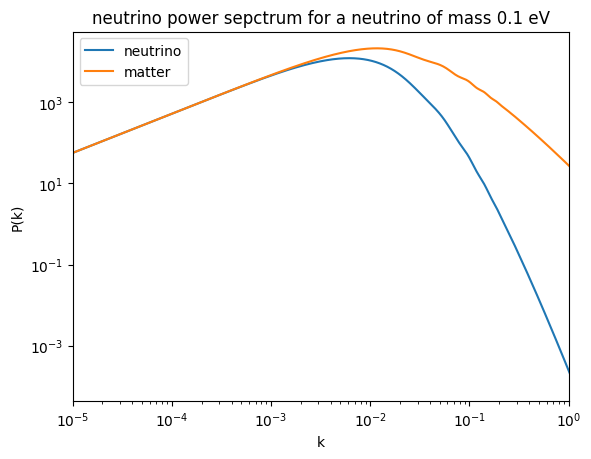

In [31]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 1e-1 # eV
kvec = np.logspace(-3,1,30)
h = 0.6704
cosmo_dict ={'h':h,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
tranf = cosmo.get_transfer(z=0)
#print(tranf.keys())
prim = cosmo.get_primordial()
#print(prim.keys())

k = tranf['k (h/Mpc)'] * h
#plt.loglog(tranf['k (h/Mpc)'],-tranf["d_ncdm[0]"])

prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
plt.figure(1)

plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
plt.xlim([1e-5,1])
plt.legend()
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("neutrino power sepctrum for a neutrino of mass %s eV" % mv_test)
#plt.ylim([1e-3,1e1])
#plt.show()